## Notebook for experimenting with MV benchmarks

In [9]:
### Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import font_manager
import os
from tqdm import tqdm
import json
import pickle
from scipy.io import loadmat
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from helper_functions.embed_methods import embed_wrapper
from helper_functions.clustering_funcs import align_clusters

sim_params = {
        'dataset': 'WebKB',
        'delete_kernels': False,
        'generate_data': True,
        'animate' : True,  #  animation generation increases the run time
        'evd_solver': 'arpack',  # 'arpack' / 'randomized' / 'svd'
        'ad_methods': ['ad', 'adm_plus', 'ncca', 'apmc'],
        'embed_dim': 30,
        'clusters': 15,
        't': 0,
        'scale': 0.1,
        'sigma_mode' : 'median',  # 'median' , 'scale'
        'missing_ratio': 0.5,  # ratio of samples missing from second view
        'cmap': 'custom',
        'reps': 10
    }

np.random.seed(42)

data_path = os.path.join("mv_datasets", f"{sim_params['dataset']}.mat")
# fig_str = os.path.join("figures", f"{sim_params['dataset']}")
# figures_path = f"{fig_str}_{sim_params['N']}_lag_{sim_params['lag']}_{sim_params['views']}_tlen_{sim_params['traj_len']}_scale_{sim_params['scale']}_final_run".replace('.', 'p')
# os.makedirs(figures_path, exist_ok=True)
# Nr = sim_params['Nr'] # number of samples in the reference set
# N_d = sim_params['N']

# with open(f"{figures_path}/sim_params.json", 'w') as fp:
#     json.dump(sim_params, fp, indent=4)

In [10]:
# Load the mat file
print(f"Loading data from: {data_path}")
data = loadmat(data_path)

# Extract views and labels
X = data['X']  # Cell array containing multiple views
y_true = data['y'].flatten()  # Ground truth labels

# Extract individual views from the cell array
view1 = X[0, 0]  # First view
view2 = X[1, 0]  # Second view

n_samples = view1.shape[0]
n_clusters = y_true.max()
missing_ratio = sim_params['missing_ratio']

# Calculate reference set size (samples with both views)
n_ref = int(n_samples * (1 - missing_ratio))

## sample reference set
ref_indices = np.random.choice(n_samples, n_ref, replace=False)
s1_ref = view1[ref_indices, :]
# organize the full set to match the reference set order
aligned_indices = np.concatenate((ref_indices, np.setdiff1d(np.arange(n_samples), ref_indices)))
s1_full = view1[aligned_indices, :]
s2_ref = view2[ref_indices, :]
s2_full = view2[aligned_indices, :]

# rearrange labels to match the new order of samples
y_true_aligned = y_true[aligned_indices]

print(f"\nDataset: {sim_params['dataset']}")
print(f"Total samples: {n_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Missing ratio: {missing_ratio}")
print(f"Reference set size (both views): {n_ref}")
print(f"Missing samples (view 1 only): {n_samples - n_ref}")
print(f"View 1 shape: {view1.shape}")
print(f"View 2 shape: {view2.shape}")
print(f"Labels shape: {y_true.shape}")
print(f"Unique labels: {np.unique(y_true)}")

Loading data from: mv_datasets\WebKB.mat

Dataset: WebKB
Total samples: 1051
Number of clusters: 2
Missing ratio: 0.5
Reference set size (both views): 525
Missing samples (view 1 only): 526
View 1 shape: (1051, 1840)
View 2 shape: (1051, 3000)
Labels shape: (1051,)
Unique labels: [1 2]


In [11]:
def calculate_purity(y_true, y_pred):
    """
    Calculate clustering purity.
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted cluster labels
    
    Returns:
    - purity score
    """
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix
    
    # Create confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    
    # Find optimal assignment
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    
    # Calculate purity
    purity = contingency_matrix[row_ind, col_ind].sum() / len(y_true)
    
    return purity


def evaluate_clustering(embedding, y_true, n_clusters, method_name):
    """
    Perform clustering on embedding and evaluate with multiple metrics.
    
    Parameters:
    - embedding: the embedding vectors
    - y_true: ground truth labels
    - n_clusters: number of clusters
    - method_name: name of the method for display
    
    Returns:
    - Dictionary with accuracy, NMI, and purity
    """
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(embedding)
    
    # Align clusters using Hungarian algorithm
    y_pred_aligned = align_clusters(y_true, y_pred)
    
    # Calculate metrics
    accuracy = np.mean(y_pred_aligned == y_true)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    purity = calculate_purity(y_true, y_pred)
    
    print(f"\n{method_name} Results:")
    print(f"  Clustering Accuracy: {accuracy:.4f}")
    print(f"  NMI: {nmi:.4f}")
    print(f"  Purity: {purity:.4f}")
    
    return {
        'method': method_name,
        'accuracy': accuracy,
        'nmi': nmi,
        'purity': purity
    }

In [ ]:
from helper_functions.embed_methods import fimvc_via_embed

mu_vec = [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]
results_opt = []
for mu in mu_vec:
                
    embedding = fimvc_via_embed(s1_ref=s1_ref, s2_ref=s2_ref, s1_full=s1_full, 
                                embed_dim=sim_params['embed_dim'], mu=mu)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(embedding)

    # Align clusters using Hungarian algorithm
    y_pred_aligned = align_clusters(y_true_aligned, y_pred)

    # Calculate metrics
    accuracy = np.mean(y_pred_aligned == y_true_aligned)
    nmi = normalized_mutual_info_score(y_true_aligned, y_pred)
    purity = calculate_purity(y_true_aligned, y_pred)
    ari = adjusted_rand_score(y_true_aligned, y_pred)

    print(f"    Accuracy: {accuracy:.4f}, NMI: {nmi:.4f}, Purity: {purity:.4f}, ARI: {ari:.4f}")
    results_opt.append({
        'mu': mu,
        'accuracy': accuracy,
        'nmi': nmi,
        'purity': purity,
        'ari': ari
    })
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_opt)



c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7745, NMI: 0.0058, Purity: 0.7745, ARI: -0.0093


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7831, NMI: 0.0107, Purity: 0.7831, ARI: 0.0098


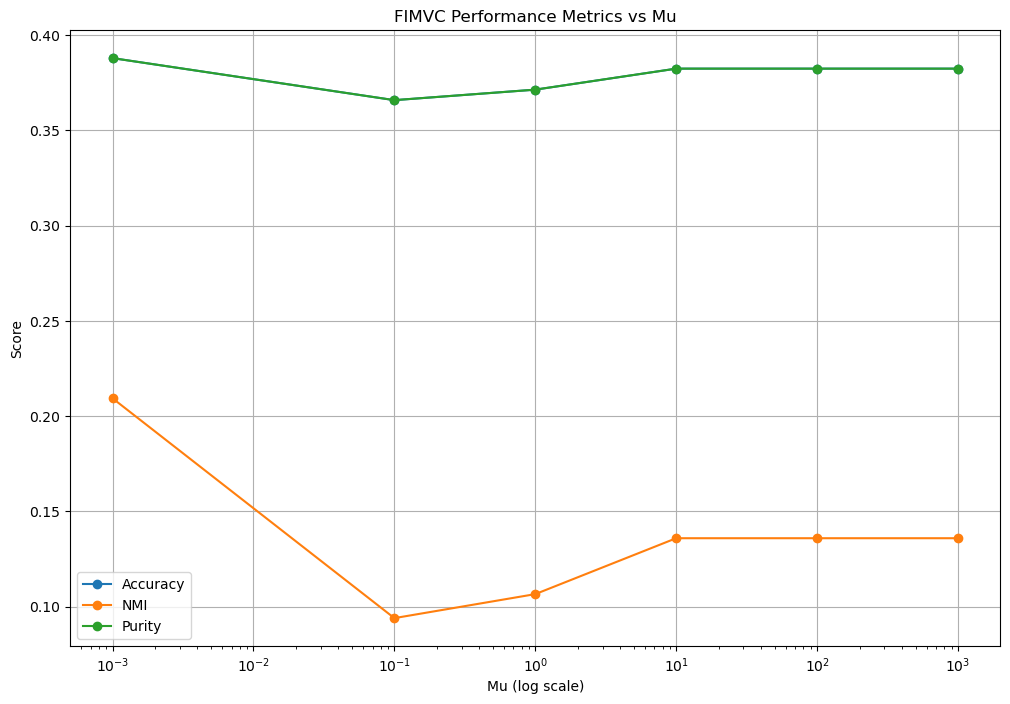

In [ ]:
## Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['mu'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['mu'], results_df['nmi'], marker='o', label='NMI')
plt.plot(results_df['mu'], results_df['purity'], marker='o', label='Purity')
plt.xscale('log')
plt.xlabel('Mu (log scale)')
plt.ylabel('Score')
plt.title('FIMVC Performance Metrics vs Mu')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from helper_functions.embed_utils import Create_Transition_Mat, Create_Asym_Tran_Kernel

# Hyperparameter tuning on scale parameter
scale_grid = [0.1, 0.3, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]

print(f"\n{'='*80}")
print("HYPERPARAMETER TUNING: Scale Parameter Grid Search")
print(f"{'='*80}")
print(f"Scale values to test: {scale_grid}")
print(f"Methods: {sim_params['ad_methods']}")
print(f"{'='*80}\n")

# Store all results
all_results = []

for scale in tqdm(scale_grid, desc="Scale values"):
    print(f"\n{'='*60}")
    print(f"Testing Scale = {scale}")
    print(f"{'='*60}")
    K1, _ = Create_Transition_Mat(s1_full, scale=scale, mode=sim_params['sigma_mode'])
    K2, _ = Create_Transition_Mat(s2_full, scale=scale, mode=sim_params['sigma_mode'])
    A1, _, _ = Create_Asym_Tran_Kernel(s1_full, s1_ref, scale=scale, mode=sim_params['sigma_mode'])
    K2_ref, _ = Create_Transition_Mat(s2_ref, scale=scale, mode=sim_params['sigma_mode'])

    for method in sim_params['ad_methods']:
        print(f"\n  Method: {method.upper()}")
        try:
            # Generate embedding using embed_wrapper with current scale
            if method == 'ad':
                
                embedding = embed_wrapper(
                    s1_full=s1_full,
                    s2_full=s2_full,
                    method=method,
                    embed_dim=sim_params['embed_dim'],
                    t=sim_params['t'],
                    K1=K1,
                    K2=K2,
                    solver=sim_params['evd_solver']
                )
            else:
                # For adm_plus, create asymmetric and symmetric kernels
                embedding = embed_wrapper(
                    s1_ref=s1_ref,
                    s1_full=s1_full,
                    s2_ref=s2_ref,
                    method=method,
                    embed_dim=sim_params['embed_dim'],
                    t=sim_params['t'],
                    K1=A1,
                    K2=K2_ref,
                    solver=sim_params['evd_solver']
                )
            
            # Perform KMeans clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            y_pred = kmeans.fit_predict(embedding)
            
            # Align clusters using Hungarian algorithm
            y_pred_aligned = align_clusters(y_true_aligned, y_pred)
            
            # Calculate metrics
            accuracy = np.mean(y_pred_aligned == y_true_aligned)
            nmi = normalized_mutual_info_score(y_true_aligned, y_pred)
            purity = calculate_purity(y_true_aligned, y_pred)
            ari = adjusted_rand_score(y_true_aligned, y_pred)
            
            print(f"    Accuracy: {accuracy:.4f}, NMI: {nmi:.4f}, Purity: {purity:.4f}, ARI: {ari:.4f}")
            
            all_results.append({
                'scale': scale,
                'method': method,
                'accuracy': accuracy,
                'nmi': nmi,
                'purity': purity,
                'ari': ari
            })
            
        except Exception as e:
            print(f"   Error at scale {scale}: {str(e)}")
            all_results.append({
                'scale': scale,
                'method': method,
                'accuracy': np.nan,
                'nmi': np.nan,
                'purity': np.nan,
                'ari': np.nan
            })

# Create results DataFrame
results_grid_df = pd.DataFrame(all_results)

# Print summary
print(f"\n{'='*80}")
print("GRID SEARCH RESULTS SUMMARY")
print(f"{'='*80}\n")
print(results_grid_df.to_string(index=False))

# Find best parameters for each method
print(f"\n{'='*80}")
print("BEST PARAMETERS BY METHOD")
print(f"{'='*80}\n")

for method in sim_params['ad_methods']:
    method_results = results_grid_df[results_grid_df['method'] == method]
    
    # Best by accuracy
    best_acc = method_results.loc[method_results['accuracy'].idxmax()]
    print(f"{method.upper()}:")
    print(f"  Best Accuracy: {best_acc['accuracy']:.4f} at scale={best_acc['scale']}")
    print(f"  Best NMI: {method_results.loc[method_results['nmi'].idxmax(), 'nmi']:.4f} at scale={method_results.loc[method_results['nmi'].idxmax(), 'scale']}")
    print(f"  Best Purity: {method_results.loc[method_results['purity'].idxmax(), 'purity']:.4f} at scale={method_results.loc[method_results['purity'].idxmax(), 'scale']}")
    print(f"  Best ARI: {method_results.loc[method_results['ari'].idxmax(), 'ari']:.4f} at scale={method_results.loc[method_results['ari'].idxmax(), 'scale']}")
    print()


HYPERPARAMETER TUNING: Scale Parameter Grid Search
Scale values to test: [0.1, 0.3, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]
Methods: ['ad', 'adm_plus', 'ncca', 'apmc']



Scale values:   0%|          | 0/12 [00:00<?, ?it/s]


Testing Scale = 0.1
 Kernel computation finished, in 0.23260283470153809 seconds
 Kernel computation finished, in 0.23260283470153809 seconds
 Kernel computation finished, in 0.2368464469909668 seconds
 Kernel computation finished, in 0.2368464469909668 seconds
 Kernel computation finished, in 0.2080235481262207 seconds
 Kernel computation finished, in 0.04391908645629883 seconds

  Method: AD
 Kernel computation finished, in 0.2080235481262207 seconds
 Kernel computation finished, in 0.04391908645629883 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3548, NMI: 0.0134, Purity: 0.3548, ARI: -0.0009

  Method: ADM_PLUS
    Accuracy: 0.3474, NMI: 0.0098, Purity: 0.3474, ARI: -0.0044

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:   8%|▊         | 1/12 [00:01<00:18,  1.70s/it]

    Accuracy: 0.3548, NMI: 0.0224, Purity: 0.3548, ARI: 0.0004

  Method: APMC
    Accuracy: 0.3566, NMI: 0.0185, Purity: 0.3566, ARI: 0.0004

Testing Scale = 0.3
 Kernel computation finished, in 0.23549652099609375 seconds
 Kernel computation finished, in 0.23549652099609375 seconds
 Kernel computation finished, in 0.2341139316558838 seconds
 Kernel computation finished, in 0.2341139316558838 seconds
 Kernel computation finished, in 0.21201229095458984 seconds
 Kernel computation finished, in 0.04388093948364258 seconds

  Method: AD
 Kernel computation finished, in 0.21201229095458984 seconds
 Kernel computation finished, in 0.04388093948364258 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3585, NMI: 0.0149, Purity: 0.3585, ARI: 0.0007

  Method: ADM_PLUS
    Accuracy: 0.3603, NMI: 0.0176, Purity: 0.3603, ARI: 0.0030

  Method: NCCA
    Accuracy: 0.3585, NMI: 0.0149, Purity: 0.3585, ARI: 0.0007

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  17%|█▋        | 2/12 [00:03<00:14,  1.47s/it]

    Accuracy: 0.3511, NMI: 0.0112, Purity: 0.3511, ARI: -0.0029

Testing Scale = 0.5
 Kernel computation finished, in 0.23639988899230957 seconds
 Kernel computation finished, in 0.23639988899230957 seconds
 Kernel computation finished, in 0.24097871780395508 seconds
 Kernel computation finished, in 0.24097871780395508 seconds
 Kernel computation finished, in 0.21095895767211914 seconds
 Kernel computation finished, in 0.04239058494567871 seconds

  Method: AD
 Kernel computation finished, in 0.21095895767211914 seconds
 Kernel computation finished, in 0.04239058494567871 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3603, NMI: 0.0206, Purity: 0.3603, ARI: 0.0029

  Method: ADM_PLUS
    Accuracy: 0.3585, NMI: 0.0196, Purity: 0.3585, ARI: 0.0016

  Method: NCCA
    Accuracy: 0.3548, NMI: 0.0122, Purity: 0.3548, ARI: -0.0017

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  25%|██▌       | 3/12 [00:04<00:12,  1.38s/it]

    Accuracy: 0.3548, NMI: 0.0122, Purity: 0.3548, ARI: -0.0017

Testing Scale = 1
 Kernel computation finished, in 0.23440790176391602 seconds
 Kernel computation finished, in 0.23440790176391602 seconds
 Kernel computation finished, in 0.23739910125732422 seconds
 Kernel computation finished, in 0.2059774398803711 seconds
 Kernel computation finished, in 0.23739910125732422 seconds
 Kernel computation finished, in 0.2059774398803711 seconds
 Kernel computation finished, in 0.04288315773010254 seconds

  Method: AD
 Kernel computation finished, in 0.04288315773010254 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3585, NMI: 0.0143, Purity: 0.3585, ARI: 0.0009

  Method: ADM_PLUS
    Accuracy: 0.5165, NMI: 0.3426, Purity: 0.5165, ARI: 0.1867

  Method: NCCA
    Accuracy: 0.4320, NMI: 0.2300, Purity: 0.4320, ARI: 0.0876

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  33%|███▎      | 4/12 [00:05<00:10,  1.35s/it]

    Accuracy: 0.2978, NMI: 0.0149, Purity: 0.2978, ARI: 0.0040

Testing Scale = 2
 Kernel computation finished, in 0.22866559028625488 seconds
 Kernel computation finished, in 0.22866559028625488 seconds
 Kernel computation finished, in 0.2354581356048584 seconds
 Kernel computation finished, in 0.2354581356048584 seconds
 Kernel computation finished, in 0.20455312728881836 seconds
 Kernel computation finished, in 0.04243278503417969 seconds

  Method: AD
 Kernel computation finished, in 0.20455312728881836 seconds
 Kernel computation finished, in 0.04243278503417969 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.4982, NMI: 0.2967, Purity: 0.4982, ARI: 0.2046

  Method: ADM_PLUS
    Accuracy: 0.3566, NMI: 0.0137, Purity: 0.3566, ARI: -0.0001

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  42%|████▏     | 5/12 [00:06<00:09,  1.33s/it]

    Accuracy: 0.4614, NMI: 0.2934, Purity: 0.4614, ARI: 0.1169

  Method: APMC
    Accuracy: 0.3070, NMI: 0.0194, Purity: 0.3070, ARI: 0.0073

Testing Scale = 3
 Kernel computation finished, in 0.23190689086914062 seconds
 Kernel computation finished, in 0.23190689086914062 seconds
 Kernel computation finished, in 0.25957202911376953 seconds
 Kernel computation finished, in 0.25957202911376953 seconds
 Kernel computation finished, in 0.3001985549926758 seconds
 Kernel computation finished, in 0.0548551082611084 seconds

  Method: AD
 Kernel computation finished, in 0.3001985549926758 seconds
 Kernel computation finished, in 0.0548551082611084 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.6673, NMI: 0.5138, Purity: 0.6673, ARI: 0.4102

  Method: ADM_PLUS
    Accuracy: 0.3805, NMI: 0.0707, Purity: 0.3805, ARI: 0.0180

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  50%|█████     | 6/12 [00:08<00:09,  1.50s/it]

    Accuracy: 0.4945, NMI: 0.3247, Purity: 0.4945, ARI: 0.1598

  Method: APMC
    Accuracy: 0.3548, NMI: 0.0165, Purity: 0.3548, ARI: -0.0008

Testing Scale = 5
 Kernel computation finished, in 0.4324376583099365 seconds
 Kernel computation finished, in 0.4324376583099365 seconds
 Kernel computation finished, in 0.281574010848999 seconds
 Kernel computation finished, in 0.281574010848999 seconds
 Kernel computation finished, in 0.24696040153503418 seconds
 Kernel computation finished, in 0.0548245906829834 seconds

  Method: AD
 Kernel computation finished, in 0.24696040153503418 seconds
 Kernel computation finished, in 0.0548245906829834 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3750, NMI: 0.0873, Purity: 0.3750, ARI: 0.0422

  Method: ADM_PLUS
    Accuracy: 0.5349, NMI: 0.3928, Purity: 0.5349, ARI: 0.2108

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  58%|█████▊    | 7/12 [00:10<00:07,  1.56s/it]

    Accuracy: 0.8603, NMI: 0.7698, Purity: 0.8603, ARI: 0.7957

  Method: APMC
    Accuracy: 0.3695, NMI: 0.1763, Purity: 0.3695, ARI: 0.0695

Testing Scale = 7
 Kernel computation finished, in 0.2713027000427246 seconds
 Kernel computation finished, in 0.2713027000427246 seconds
 Kernel computation finished, in 0.28940367698669434 seconds
 Kernel computation finished, in 0.28940367698669434 seconds
 Kernel computation finished, in 0.2658097743988037 seconds
 Kernel computation finished, in 0.056359052658081055 seconds

  Method: AD
 Kernel computation finished, in 0.2658097743988037 seconds
 Kernel computation finished, in 0.056359052658081055 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3934, NMI: 0.1313, Purity: 0.3934, ARI: 0.0757

  Method: ADM_PLUS
    Accuracy: 0.3272, NMI: 0.1035, Purity: 0.3272, ARI: -0.0075

  Method: NCCA
    Accuracy: 0.5882, NMI: 0.4790, Purity: 0.5882, ARI: 0.3791

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  67%|██████▋   | 8/12 [00:11<00:06,  1.57s/it]

    Accuracy: 0.3217, NMI: 0.0532, Purity: 0.3217, ARI: 0.0170

Testing Scale = 10
 Kernel computation finished, in 0.329789400100708 seconds
 Kernel computation finished, in 0.329789400100708 seconds
 Kernel computation finished, in 0.5476646423339844 seconds
 Kernel computation finished, in 0.5476646423339844 seconds
 Kernel computation finished, in 0.34574127197265625 seconds
 Kernel computation finished, in 0.044914960861206055 seconds

  Method: AD
 Kernel computation finished, in 0.34574127197265625 seconds
 Kernel computation finished, in 0.044914960861206055 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3088, NMI: 0.0311, Purity: 0.3088, ARI: -0.0214

  Method: ADM_PLUS
    Accuracy: 0.3548, NMI: 0.0160, Purity: 0.3548, ARI: -0.0012

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  75%|███████▌  | 9/12 [00:13<00:05,  1.70s/it]

    Accuracy: 0.6452, NMI: 0.5057, Purity: 0.6452, ARI: 0.3602

  Method: APMC
    Accuracy: 0.2904, NMI: 0.0258, Purity: 0.2904, ARI: -0.0002

Testing Scale = 15
 Kernel computation finished, in 0.24688315391540527 seconds
 Kernel computation finished, in 0.24688315391540527 seconds
 Kernel computation finished, in 0.24749422073364258 seconds
 Kernel computation finished, in 0.24749422073364258 seconds
 Kernel computation finished, in 0.23001313209533691 seconds
 Kernel computation finished, in 0.04288458824157715 seconds

  Method: AD
 Kernel computation finished, in 0.23001313209533691 seconds
 Kernel computation finished, in 0.04288458824157715 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3824, NMI: 0.0793, Purity: 0.3824, ARI: 0.0179

  Method: ADM_PLUS
    Accuracy: 0.3750, NMI: 0.0715, Purity: 0.3750, ARI: 0.0156

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  83%|████████▎ | 10/12 [00:15<00:03,  1.60s/it]

    Accuracy: 0.7371, NMI: 0.6462, Purity: 0.7371, ARI: 0.5852

  Method: APMC
    Accuracy: 0.2904, NMI: 0.0537, Purity: 0.2904, ARI: -0.0011

Testing Scale = 20
 Kernel computation finished, in 0.2344062328338623 seconds
 Kernel computation finished, in 0.2344062328338623 seconds
 Kernel computation finished, in 0.23798131942749023 seconds
 Kernel computation finished, in 0.23798131942749023 seconds
 Kernel computation finished, in 0.21958184242248535 seconds
 Kernel computation finished, in 0.042058706283569336 seconds

  Method: AD
 Kernel computation finished, in 0.21958184242248535 seconds
 Kernel computation finished, in 0.042058706283569336 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.4246, NMI: 0.1252, Purity: 0.4246, ARI: 0.0418

  Method: ADM_PLUS
    Accuracy: 0.5368, NMI: 0.3578, Purity: 0.5368, ARI: 0.2536

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values:  92%|█████████▏| 11/12 [00:16<00:01,  1.60s/it]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.

    Accuracy: 0.5551, NMI: 0.4334, Purity: 0.5551, ARI: 0.2504

  Method: APMC
    Accuracy: 0.4007, NMI: 0.1966, Purity: 0.4007, ARI: 0.0857

Testing Scale = 30
 Kernel computation finished, in 0.2933070659637451 seconds
 Kernel computation finished, in 0.2933070659637451 seconds
 Kernel computation finished, in 0.24637556076049805 seconds
 Kernel computation finished, in 0.24637556076049805 seconds
 Kernel computation finished, in 0.21495676040649414 seconds
 Kernel computation finished, in 0.04487943649291992 seconds

  Method: AD
 Kernel computation finished, in 0.21495676040649414 seconds
 Kernel computation finished, in 0.04487943649291992 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


    Accuracy: 0.3842, NMI: 0.0866, Purity: 0.3842, ARI: 0.0239

  Method: ADM_PLUS
    Accuracy: 0.4430, NMI: 0.2729, Purity: 0.4430, ARI: 0.1046

  Method: NCCA
    Accuracy: 0.7390, NMI: 0.6469, Purity: 0.7390, ARI: 0.5870

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Scale values: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it]

    Accuracy: 0.3217, NMI: 0.0565, Purity: 0.3217, ARI: 0.0191

GRID SEARCH RESULTS SUMMARY

 scale   method  accuracy      nmi   purity       ari
   0.1       ad  0.354779 0.013441 0.354779 -0.000904
   0.1 adm_plus  0.347426 0.009785 0.347426 -0.004407
   0.1     ncca  0.354779 0.022412 0.354779  0.000399
   0.1     apmc  0.356618 0.018522 0.356618  0.000378
   0.3       ad  0.358456 0.014884 0.358456  0.000677
   0.3 adm_plus  0.360294 0.017599 0.360294  0.003048
   0.3     ncca  0.358456 0.014884 0.358456  0.000677
   0.3     apmc  0.351103 0.011204 0.351103 -0.002862
   0.5       ad  0.360294 0.020635 0.360294  0.002900
   0.5 adm_plus  0.358456 0.019563 0.358456  0.001621
   0.5     ncca  0.354779 0.012220 0.354779 -0.001659
   0.5     apmc  0.354779 0.012220 0.354779 -0.001659
   1.0       ad  0.358456 0.014347 0.358456  0.000856
   1.0 adm_plus  0.516544 0.342639 0.516544  0.186669
   1.0     ncca  0.431985 0.230022 0.431985  0.087638
   1.0     apmc  0.297794 0.014889 0.297794

In [ ]:
for method in sim_params['ad_methods']:
    method_results = results_grid_df[results_grid_df['method'] == method]
    
    # Best by accuracy
    best_acc = method_results.loc[method_results['accuracy'].idxmax()]
    print(f"{method.upper()}:")
    print(f"  Best Accuracy: {best_acc['accuracy']:.4f} at scale={best_acc['scale']}")
    print(f"  Best NMI: {method_results.loc[method_results['nmi'].idxmax(), 'nmi']:.4f} at scale={method_results.loc[method_results['nmi'].idxmax(), 'scale']}")
    print(f"  Best Purity: {method_results.loc[method_results['purity'].idxmax(), 'purity']:.4f} at scale={method_results.loc[method_results['purity'].idxmax(), 'scale']}")
    print(f"  Best ARI: {method_results.loc[method_results['ari'].idxmax(), 'ari']:.4f} at scale={method_results.loc[method_results['ari'].idxmax(), 'scale']}")
    print()

AD:
  Best Accuracy: 0.6673 at scale=3.0
  Best NMI: 0.5138 at scale=3.0
  Best Purity: 0.6673 at scale=3.0
  Best ARI: 0.4102 at scale=3.0

ADM_PLUS:
  Best Accuracy: 0.5368 at scale=20.0
  Best NMI: 0.3928 at scale=5.0
  Best Purity: 0.5368 at scale=20.0
  Best ARI: 0.2536 at scale=20.0

NCCA:
  Best Accuracy: 0.8603 at scale=5.0
  Best NMI: 0.7698 at scale=5.0
  Best Purity: 0.8603 at scale=5.0
  Best ARI: 0.7957 at scale=5.0

APMC:
  Best Accuracy: 0.4007 at scale=20.0
  Best NMI: 0.1966 at scale=20.0
  Best Purity: 0.4007 at scale=20.0
  Best ARI: 0.0857 at scale=20.0



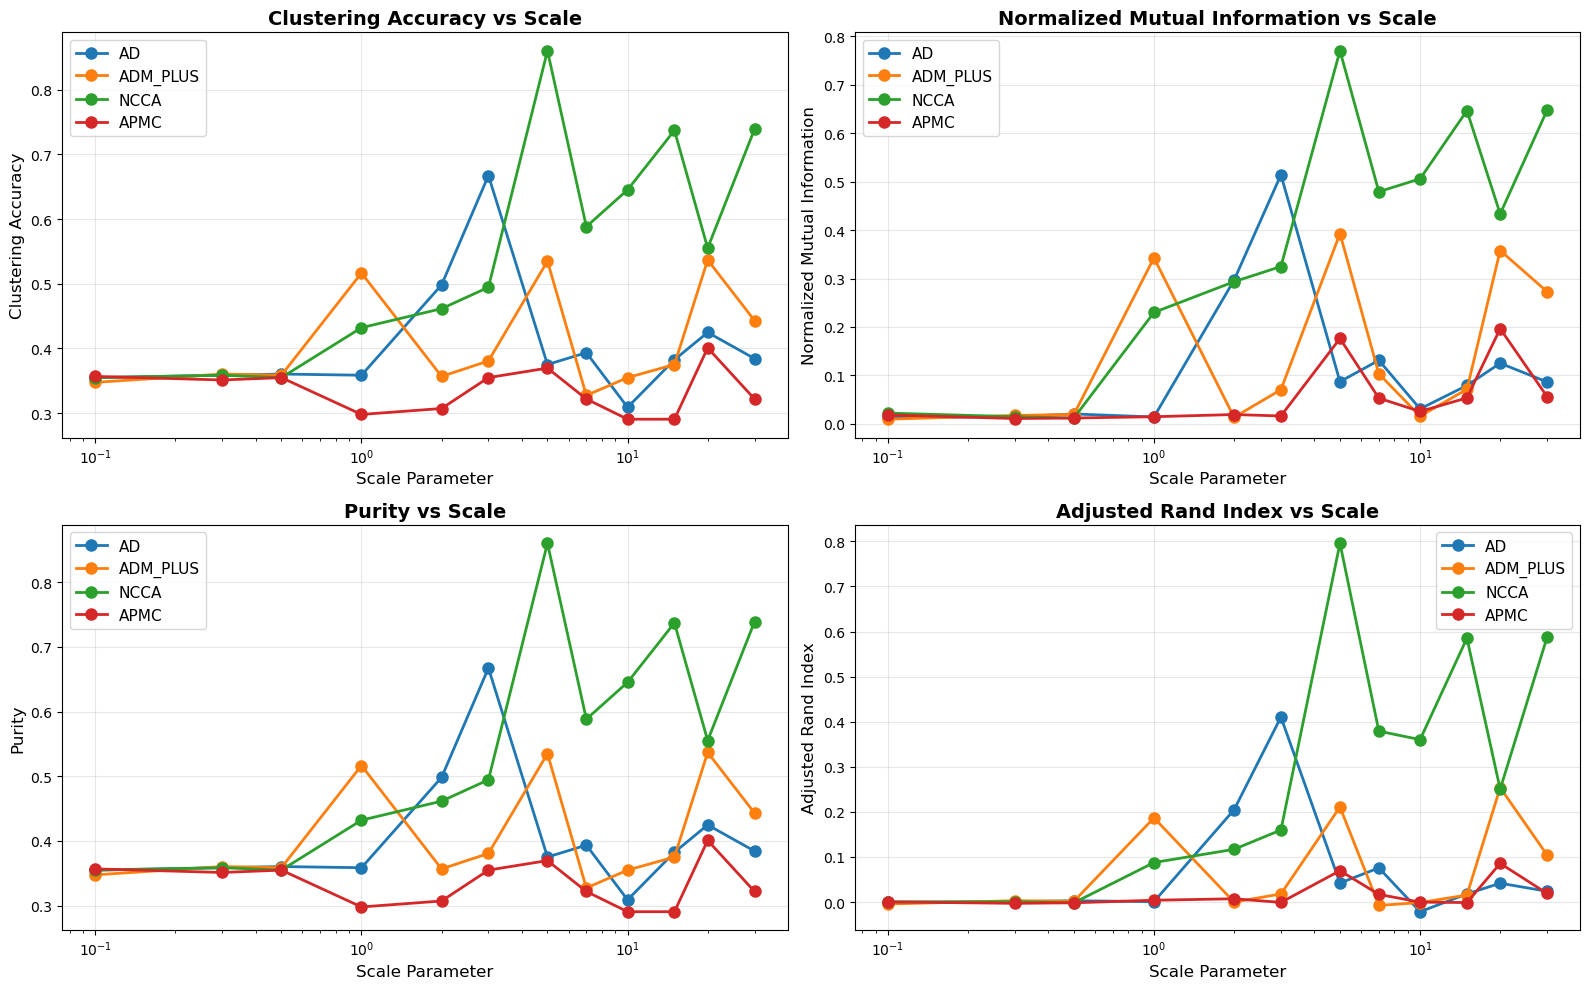


Dataset: BBCSport
Missing ratio: 0.5
Embedding dimension: 30
Diffusion time: 0


In [ ]:
# Visualize grid search results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

metrics = ['accuracy', 'nmi', 'purity', 'ari']
titles = ['Clustering Accuracy', 'Normalized Mutual Information', 'Purity', 'Adjusted Rand Index']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    
    for method in sim_params['ad_methods']:
        method_data = results_grid_df[results_grid_df['method'] == method]
        ax.plot(method_data['scale'], method_data[metric], marker='o', label=method.upper(), linewidth=2, markersize=8)
    
    ax.set_xlabel('Scale Parameter', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs Scale', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

plt.tight_layout()
plt.show()

print(f"\nDataset: {sim_params['dataset']}")
print(f"Missing ratio: {sim_params['missing_ratio']}")
print(f"Embedding dimension: {sim_params['embed_dim']}")
print(f"Diffusion time: {sim_params['t']}")